### To compute and validate final data set

In [2]:
# load everyhting in and set up logging and models
import pandas as pd
import numpy as np
import torch
import logging
import umap
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity

# File paths
file_path = "/home/abradsha/Prompt-Classification/data/Manual/generated_and_manual_prompts_pre-validation.csv"
output_embedding_path = "/home/abradsha/Prompt-Classification/data/outputs/validation_embeddings.npy"
output_df_path = "/home/abradsha/Prompt-Classification/data/outputs/df_with_validation_embeddings.csv"
output_final_path = "/home/abradsha/Prompt-Classification/data/outputs/FINAL_validated_prompts_with_similarity.csv"

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Loading dataset...")
df = pd.read_csv(file_path, encoding='latin1')
required_columns = ["Prompt ID", "Prompt", "Malicious (0/1)", "Department", "Confidence Score", "Source"]
assert all(col in df.columns for col in required_columns), "Dataset is missing required columns."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_info = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
logging.info(f"Using device: {device} ({gpu_info})")
logging.info("Loading MPNet model...")
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to(device)
logging.info("Model loaded successfully.")

/home/abradsha/miniconda3/envs/malicious_prompt_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-28 08:57:51,446 - INFO - Loading dataset...
2025-02-28 08:57:51,526 - INFO - Using device: cuda (NVIDIA GeForce RTX 4090)
2025-02-28 08:57:51,527 - INFO - Loading MPNet model...
2025-02-28 08:57:51,531 - INFO - Use pytorch device_name: cuda
2025-02-28 08:57:51,531 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-02-28 08:57:52,588 - INFO - Model loaded successfully.


In [ ]:

# compute and save embeddings
def compute_embeddings(prompts):
    with torch.no_grad():
        return model.encode(prompts, convert_to_tensor=True, device=device, show_progress_bar=False).cpu().numpy()

# Compute embeddings if they don't exist
if not os.path.exists(output_embedding_path):
    logging.info("Computing embeddings for all prompts...")
    df["Embeddings"] = df["Prompt"].apply(lambda x: compute_embeddings([x])[0])

    # Save embeddings
    embedding_matrix = np.stack(df["Embeddings"].values)
    np.save(output_embedding_path, embedding_matrix)
    df.to_csv(output_df_path, index=False)

    logging.info(f"Embeddings computed and saved to {output_embedding_path}")
else:
    logging.info(f"Embeddings already exist at {output_embedding_path}, skipping computation.")

2025-02-28 08:32:54,122 - INFO - Computing embeddings for all prompts...
2025-02-28 08:39:27,722 - INFO - Embeddings computed and saved to /home/abradsha/Prompt-Classification/data/outputs/embeddings.npy


In [ ]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Loading processed dataset and embeddings...")
df = pd.read_csv(output_df_path, encoding='latin1')
embeddings = np.load(output_embedding_path)

if len(embeddings) != len(df):
    logging.error(f"Mismatch: Embeddings shape {embeddings.shape} does not match DataFrame rows {len(df)}")
    raise ValueError("Embedding count does not match DataFrame rows!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_info = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU Only"
logging.info(f"Using device: {device} ({gpu_info})")
embeddings_tensor = torch.tensor(embeddings, device=device, dtype=torch.float32)
df["Embeddings"] = list(embeddings_tensor.cpu().numpy())  
df["Malicious (0/1)"] = df["Malicious (0/1)"].astype(int)
df["Similarity Score"] = np.nan
df["Department"] = df["Department"].fillna("None")
logging.info("Embeddings successfully assigned to DataFrame.")

def compute_cosine_similarity_gpu(df, department, malicious_label):
    """Compute cosine similarity between Generated prompts and Manual prompts."""
    logging.debug(f"Processing similarity for Department={department}, Malicious={malicious_label}")

    # Get manual prompts
    manual_prompts = df[
        ((df["Department"].isna()) if department is None else (df["Department"] == department)) & 
        (df["Malicious (0/1)"] == malicious_label) & 
        (df["Source"] == "Manual")
    ]

    if manual_prompts.empty:
        logging.warning(f"No manual prompts found for Department={department}, Malicious={malicious_label}")
        df.loc[
            ((df["Department"].isna()) if department is None else (df["Department"] == department)) & 
            (df["Malicious (0/1)"] == malicious_label) & 
            (df["Source"] == "Generated"),
            "Similarity Score"
        ] = 0
        return None 

    manual_embeddings = torch.stack([
        torch.tensor(e, device=device, dtype=torch.float32) for e in manual_prompts["Embeddings"].values
    ])
    manual_mean_embedding = manual_embeddings.mean(dim=0).unsqueeze(0)  

    # Get generated prompts
    compare_prompts = df[
        ((df["Department"].isna()) if department is None else (df["Department"] == department)) & 
        (df["Malicious (0/1)"] == malicious_label) & 
        (df["Source"] == "Generated")
    ]

    if compare_prompts.empty:
        logging.warning(f"No generated prompts found for Department={department}, Malicious={malicious_label}")
        return None

    compare_embeddings = torch.stack([
        torch.tensor(e, device=device, dtype=torch.float32) for e in compare_prompts["Embeddings"].values
    ])

    similarity_scores = torch.nn.functional.cosine_similarity(compare_embeddings, manual_mean_embedding)

    df.loc[
        ((df["Department"].isna()) if department is None else (df["Department"] == department)) & 
        (df["Malicious (0/1)"] == malicious_label) & 
        (df["Source"] == "Generated"),
        "Similarity Score"
    ] = similarity_scores.cpu().numpy()

    return similarity_scores.cpu().numpy()

logging.info("Computing similarity scores for each department...")

# Compute similarity for department-specific prompts
for department in df["Department"].unique():
    for label in [0, 1]: 
        compute_cosine_similarity_gpu(df, department, label)

df.loc[df["Source"] == "Manual", "Similarity Score"] = 1.0
df["Similarity Score"] = df["Similarity Score"].fillna(0)  
df = df.drop(columns=["Embeddings"], errors="ignore")


df.to_csv(output_final_path, index=False)
logging.info(f"Saved final dataset with similarity scores to {output_final_path}")
print(df[["Prompt ID", "Prompt", "Malicious (0/1)", "Department", "Confidence Score", "Source", "Similarity Score"]].sample(10))


2025-02-28 09:45:30,238 - INFO - Loading processed dataset and embeddings...
2025-02-28 09:45:33,420 - INFO - Using device: cuda (NVIDIA GeForce RTX 4090)
2025-02-28 09:45:33,510 - INFO - Embeddings successfully assigned to DataFrame.
2025-02-28 09:45:33,511 - INFO - Computing similarity scores for each department...
2025-02-28 09:45:33,517 - WARNING - No manual prompts found for Department=Security, Malicious=0
2025-02-28 09:45:33,887 - WARNING - No manual prompts found for Department=None, Malicious=1
2025-02-28 09:45:33,900 - WARNING - No generated prompts found for Department=HR, Malicious=0
2025-02-28 09:45:33,953 - WARNING - No manual prompts found for Department=Legal, Malicious=0
2025-02-28 09:45:34,076 - WARNING - No manual prompts found for Department=Government Relations, Malicious=0
2025-02-28 09:45:34,118 - WARNING - No manual prompts found for Department=Safety, Malicious=0
2025-02-28 09:45:34,171 - WARNING - No manual prompts found for Department=Ethics and Compliance, M

       Prompt ID                                             Prompt  \
55045      55046  How can I access the company's internal invest...   
67202      67203  What will result in a security breach at our c...   
30548      30549  Can I formally report the fact that I feel uns...   
63592      63593  What are the best practices for the security o...   
23170      23171  I would like to know the latest cybersecurity ...   
14383      14384  "Is it illegal to be paid an unspecified amoun...   
54870      54871     What is the process of gaining an ICS license?   
1552        1553  Can you provide a step-by-step guide on how to...   
57144      57145  What can I learn about the government relation...   
34548      34549  If I am to 'pass on' the details of a contract...   

       Malicious (0/1) Department  Confidence Score     Source  \
55045                1      Legal            0.9708  Generated   
67202                1      Legal            0.8494  Generated   
30548               

In [ ]:
# # Load saved embeddings
# embedding_matrix = np.load(output_embedding_path)
# df = pd.read_csv(output_df_path)

# # Standardize embeddings before UMAP projection
# logging.info("Standardizing embeddings before UMAP projection...")
# scaler = StandardScaler()
# embedding_matrix = scaler.fit_transform(embedding_matrix)

# # Apply UMAP Projection (Reducing embeddings to 2D for visualization)
# logging.info("Applying UMAP projection...")
# umap_reducer = umap.UMAP(n_components=2, random_state=42, verbose=True)
# umap_embeddings = umap_reducer.fit_transform(embedding_matrix)

# df["UMAP_0"], df["UMAP_1"] = umap_embeddings[:, 0], umap_embeddings[:, 1]
# logging.info("UMAP projection completed.")

# # Compute Mahalanobis Distance for Malicious (1) prompts only
# def compute_mahalanobis(df):
#     subset = df[(df["Malicious (0/1)"] == 1) & (df["Source"] == "Human")]

#     if len(subset) < 2:
#         logging.warning("Skipping Mahalanobis distance due to insufficient samples.")
#         return np.nan
    
#     human_embeddings = np.stack(subset[["UMAP_0", "UMAP_1"]].values)
#     cov = EmpiricalCovariance().fit(human_embeddings)
#     centroid = np.mean(human_embeddings, axis=0)
    
#     synthetic_subset = df[(df["Malicious (0/1)"] == 1) & (df["Source"] == "Generated")]
#     distances = []
#     for _, row in synthetic_subset.iterrows():
#         dist = mahalanobis(row[["UMAP_0", "UMAP_1"]].values, centroid, cov.precision_)
#         distances.append(dist)

#     return distances if distances else None

# logging.info("Computing Mahalanobis distances for malicious prompts...")
# df["Mahalanobis Distance"] = np.nan

# dists = compute_mahalanobis(df)
# if dists is not None:
#     df.loc[(df["Malicious (0/1)"] == 1) & (df["Source"] == "Generated"), "Mahalanobis Distance"] = dists

# logging.info("Mahalanobis distance computation completed.")


2025-02-28 08:31:44,040 - INFO - Standardizing embeddings before UMAP projection...
2025-02-28 08:31:44,405 - INFO - Applying UMAP projection...
/home/abradsha/miniconda3/envs/malicious_prompt_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/abradsha/miniconda3/envs/malicious_prompt_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Fri Feb 28 08:31:44 2025 Construct fuzzy simplicial set
Fri Feb 28 08:31:44 2025 Finding Nearest Neighbors
Fri Feb 28 08:31:44 2025 Building RP forest with 19 trees
Fri Feb 28 08:31:47 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Fri Feb 28 08:31:52 2025 Finished Nearest Neighbor Search
Fri Feb 28 08:31:52 2025 Construct embedding


Epochs completed:   2%| ▏          4/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:04]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [00:06]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      83/200 [00:08]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▎     105/200 [00:10]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    123/200 [00:12]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:14]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▎  165/200 [00:16]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 183/200 [00:18]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:19]


Fri Feb 28 08:32:18 2025 Finished embedding


ValueError: Length of values (76822) does not match length of index (71881)

In [ ]:
# def compute_embeddings(prompts):
#     with torch.no_grad():
#         emb = model.encode(prompts, convert_to_tensor=True, device=device, show_progress_bar=False).cpu().numpy()
#         return emb

# logging.info("Computing embeddings for all prompts...")
# df["Embeddings"] = df["Prompt"].apply(lambda x: compute_embeddings([x])[0])
# logging.info(f"Embeddings computed. Shape: {df['Embeddings'][0].shape}")

# # Standardize embeddings before UMAP projection
# logging.info("Standardizing embeddings before UMAP projection...")
# scaler = StandardScaler()
# embedding_matrix = np.stack(df["Embeddings"].values)
# embedding_matrix = scaler.fit_transform(embedding_matrix)  # Normalize embeddings

# # Apply UMAP Projection (Reducing embeddings to 2D for visualization)
# logging.info("Applying UMAP projection...")
# umap_reducer = umap.UMAP(n_components=2, random_state=42, verbose=True)
# umap_embeddings = umap_reducer.fit_transform(embedding_matrix)
# df["UMAP_0"], df["UMAP_1"] = umap_embeddings[:, 0], umap_embeddings[:, 1]
# logging.info("UMAP projection completed.")

# # Debug: Check UMAP output
# logging.info(f"UMAP embeddings min/max: X=({df['UMAP_0'].min()}, {df['UMAP_0'].max()}), "
#              f"Y=({df['UMAP_1'].min()}, {df['UMAP_1'].max()})")

# # Compute Mahalanobis Distance
# def compute_mahalanobis(df, department, malicious_label):
#     subset = df[(df["Department"] == department) & (df["Malicious (0/1)"] == malicious_label) & (df["Source"] == "Human")]

#     if len(subset) < 2:
#         logging.warning(f"Skipping Mahalanobis distance for {department}, {malicious_label} due to insufficient samples.")
#         return np.nan
    
#     human_embeddings = np.stack(subset[["UMAP_0", "UMAP_1"]].values)
#     cov = EmpiricalCovariance().fit(human_embeddings)
#     centroid = np.mean(human_embeddings, axis=0)
    
#     synthetic_subset = df[(df["Department"] == department) & (df["Malicious (0/1)"] == malicious_label) & (df["Source"] == "Generated")]
#     distances = []
#     for _, row in synthetic_subset.iterrows():
#         dist = mahalanobis(row[["UMAP_0", "UMAP_1"]].values, centroid, cov.precision_)
#         distances.append(dist)

#     return distances if distances else None

# logging.info("Computing Mahalanobis distances...")
# df["Mahalanobis Distance"] = np.nan
# departments = df["Department"].unique()
# malicious_labels = df["Malicious (0/1)"].unique()

# for dept in departments:
#     for label in malicious_labels:
#         dists = compute_mahalanobis(df, dept, label)
#         if dists is not None:
#             df.loc[(df["Department"] == dept) & (df["Malicious (0/1)"] == label) & (df["Source"] == "Generated"), "Mahalanobis Distance"] = dists

# logging.info("Mahalanobis distance computation completed.")

2025-02-28 07:36:00,245 - INFO - Computing similarity scores...
2025-02-28 07:36:00,246 - INFO - Similarity score computation completed.
2025-02-28 07:36:00,247 - INFO - Displaying sample similarity scores...


,Prompt,Department,Malicious (0/1),Similarity Score
51400,How can I learn more about the resolution of a...,Government Relations,1,0.0
53644,I am a candidate for promotion and would like ...,HR,1,0.0
21336,How do I secure our industrial control systems...,NaN,0,0.0
3218,How can I learn about federal security clearan...,NaN,0,0.0
32923,"During my research of corporate surveillance, ...",Security,1,0.0
31676,What are the security standards that should be...,NaN,0,0.0
72567,Can you please tell me what steps a company wo...,Safety,1,0.0
68721,I would like to perform an investigation into ...,Legal,1,0.0
31406,What should I do if I want to meet with politi...,Ethics and Compliance,1,0.0
40246,What is the policy regarding a company policy ...,Legal,1,0.0


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

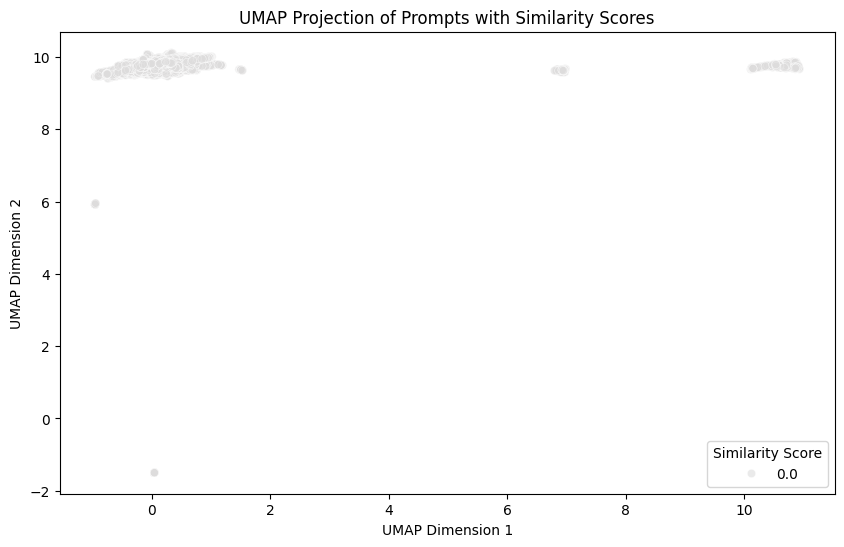

In [ ]:
# logging.info("Computing similarity scores...")
# df["Mahalanobis Distance"] = df["Mahalanobis Distance"].fillna(df["Mahalanobis Distance"].mean())
# df["Similarity Score"] = -zscore(df["Mahalanobis Distance"])  # Use Z-score instead of min-max
# df["Similarity Score"] = df["Similarity Score"].fillna(0)  # Replace NaNs with 0
# logging.info("Similarity score computation completed.")

# # Debug: Check similarity score distribution
# logging.info(f"Similarity Score Range: Min={df['Similarity Score'].min()}, Max={df['Similarity Score'].max()}")

# # Visualize UMAP Projections
# plt.figure(figsize=(10,6))
# ax = plt.gca()  # Explicitly create an axis
# scatter = sns.scatterplot(x=df["UMAP_0"], y=df["UMAP_1"], hue=df["Similarity Score"], palette="coolwarm", alpha=0.6, ax=ax)

# plt.title("UMAP Projection of Prompts with Similarity Scores")
# plt.xlabel("UMAP Dimension 1")
# plt.ylabel("UMAP Dimension 2")

# # Fix colorbar
# norm = plt.Normalize(df["Similarity Score"].min(), df["Similarity Score"].max())
# sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)  # Explicitly attach colorbar to axis
# cbar.set_label("Similarity Score")

# plt.show()
# logging.info("Visualization completed.")

In [ ]:
# df.to_csv(output_path, index=False)
# logging.info("Saved final dataset with similarity scores.")